In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random
from sklearn.preprocessing import normalize

from collections import Counter
from scipy.stats import mode

In [2]:
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\explod_feats.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\control_feats.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\sd_feats.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\cosine\cosine_centroid.pt"


In [3]:
exp = torch.load(exp_save_path_torch)
control = torch.load(control_save_path_torch)
sd = torch.load(sd_save_path_torch)
cosine_centroid = torch.load(cosine_centroid_save_path_torch)
print(exp.shape)
print(control.shape)
print(sd.shape)
print(cosine_centroid.shape)

torch.Size([29, 512])
torch.Size([120, 512])
torch.Size([103, 512])
torch.Size([512])


C:\Users\k54739\AppData\Local\Temp\ipykernel_26596\3916985452.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_save_path_torch)
C:\Users\k54739\AppDa

In [4]:
# Convert features and labels to NumPy arrays
control_np = control.numpy()  # 120 Features in shape (120, 512)
control_np_norm = normalize(control_np, axis=1)
control_np_norm.shape

(120, 512)

In [5]:
sd_np = sd.numpy()  # 103 Features in shape (103, 512)
sd_np_norm = normalize(sd_np, axis=1)
sd_np_norm.shape

(103, 512)

In [6]:
exp_np = exp.numpy()  # 29 Features in shape (29, 512)
exp_np_norm = normalize(exp_np, axis=1)
exp_np_norm.shape


(29, 512)

In [7]:
exp_np_norm

array([[0.09942402, 0.        , 0.        , ..., 0.        , 0.        ,
        0.05314087],
       [0.05676892, 0.        , 0.00059459, ..., 0.        , 0.00559864,
        0.0914542 ],
       [0.03055801, 0.        , 0.00686699, ..., 0.        , 0.06694178,
        0.06710588],
       ...,
       [0.        , 0.00032315, 0.07815263, ..., 0.        , 0.06852816,
        0.07620089],
       [0.04429684, 0.        , 0.0148464 , ..., 0.        , 0.        ,
        0.13119867],
       [0.08297585, 0.        , 0.0030582 , ..., 0.        , 0.0054707 ,
        0.11982341]], dtype=float32)

In [8]:
cosine_centroid = cosine_centroid.numpy()
print(len(cosine_centroid))
cosine_centroid

512


array([1.15598113e-02, 4.67950372e-03, 6.05678811e-02, 3.97132080e-02,
       6.22929986e-02, 5.17932542e-02, 1.90802872e-02, 8.08006403e-03,
       3.38454371e-02, 9.24501245e-02, 4.76434767e-02, 2.14309413e-04,
       1.47157980e-02, 4.39299084e-02, 2.07922707e-02, 8.76266483e-02,
       4.51024099e-03, 2.02452289e-02, 1.02720359e-01, 3.36181500e-02,
       5.73134539e-02, 4.59700931e-02, 1.96533594e-02, 4.41949990e-02,
       4.64943211e-02, 8.68415164e-02, 2.48886070e-03, 3.11143059e-02,
       3.19192448e-02, 3.00994783e-02, 5.24901817e-02, 5.94389127e-02,
       1.92603947e-02, 4.25757926e-02, 5.99674322e-04, 8.55245156e-02,
       3.23484668e-02, 1.06046327e-01, 6.63184118e-02, 5.65145204e-03,
       2.28252425e-03, 5.34213348e-03, 8.30309599e-03, 5.05610267e-02,
       1.51367160e-02, 2.51264247e-02, 1.20286566e-02, 7.87353398e-02,
       1.38669667e-02, 3.57596289e-03, 1.14059459e-01, 5.19641733e-02,
       9.90687800e-03, 2.19089293e-02, 6.54568893e-02, 3.10062713e-02,
      

In [19]:
import numpy as np

# Calculate the L2 norm of each row in exp_np_norm
norms = np.linalg.norm(exp_np_norm, axis=1)

# Check if all norms are close to 1
if np.allclose(norms, 1.0, atol=1e-6):
    print("All feature vectors are normalized.")
else:
    print("Some feature vectors are not normalized.")
    print("Norms:", norms)


All feature vectors are normalized.


In [9]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Ensure cosine centroid is a 2D array with shape (1, 512)
cosine_centroid = cosine_centroid.reshape(1, -1)  # Shape: [1, 512]

# Calculate cosine distances for each dataset
control_cosine_distances = 1 - cosine_similarity(control_np_norm, cosine_centroid).flatten()  # Shape: [120]
exp_cosine_distances = 1 - cosine_similarity(exp_np_norm, cosine_centroid).flatten()  # Shape: [29]
sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()  # Shape: [103]

# Print shapes to verify
print("Control Cosine Distances Shape:", control_cosine_distances.shape)  # Should be [120]
print("Exp Cosine Distances Shape:", exp_cosine_distances.shape)          # Should be [29]
print("SD Cosine Distances Shape:", sd_cosine_distances.shape)            # Should be [103]


Control Cosine Distances Shape: (120,)
Exp Cosine Distances Shape: (29,)
SD Cosine Distances Shape: (103,)


import matplotlib.pyplot as plt
# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(control_cosine_distances, bins=20, alpha=0.6, label="Control", color="green", edgecolor="black")
plt.hist(exp_cosine_distances, bins=20, alpha=0.6, label="Exploded", color="blue", edgecolor="black")
plt.hist(sd_cosine_distances, bins=20, alpha=0.6, label="Single Dose", color="orange", edgecolor="black")

# Customize plot
plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
plt.xlabel("Cosine Distance", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Show plot
plt.show()

In [28]:
import torch
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def calculate_and_plot_cosine_distances(exp_path, control_path, sd_path, centroid_path, bins=20):
    """
    Calculate cosine distances between a centroid and features from multiple groups,
    then plot histograms of these distances.

    Parameters:
        exp_path (str): Path to the exploded features .pt file.
        control_path (str): Path to the control features .pt file.
        sd_path (str): Path to the single-dose features .pt file.
        centroid_path (str): Path to the centroid .pt file.
        bins (int): Number of bins for the histogram.
    """
    # Load data
    exp = torch.load(exp_path)
    control = torch.load(control_path)
    sd = torch.load(sd_path)
    cosine_centroid = np.load(centroid_path)

    # Convert tensors to NumPy arrays and normalize
    exp_np_norm = normalize(exp.numpy(), axis=1)
    control_np_norm = normalize(control.numpy(), axis=1)
    sd_np_norm = normalize(sd.numpy(), axis=1)

    # Ensure centroid is reshaped correctly
    cosine_centroid = cosine_centroid.reshape(1, -1)  # Shape: [1, 512]

    # Calculate cosine distances
    control_cosine_distances = 1 - cosine_similarity(control_np_norm, cosine_centroid).flatten()
    exp_cosine_distances = 1 - cosine_similarity(exp_np_norm, cosine_centroid).flatten()
    sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()

    # Plot histograms
    plt.figure(figsize=(12, 6))
    plt.hist(control_cosine_distances, bins=bins, alpha=0.6, label="Control", color="green", edgecolor="black")
    plt.hist(exp_cosine_distances, bins=bins, alpha=0.6, label="Exploded", color="blue", edgecolor="black")
    plt.hist(sd_cosine_distances, bins=bins, alpha=0.6, label="Single Dose", color="orange", edgecolor="black")

    # Customize plot
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

    # Return calculated distances for further use
    return {
        "control_cosine_distances": control_cosine_distances,
        "exp_cosine_distances": exp_cosine_distances,
        "sd_cosine_distances": sd_cosine_distances
    }


C:\Users\k54739\AppData\Local\Temp\ipykernel_10396\3188667897.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

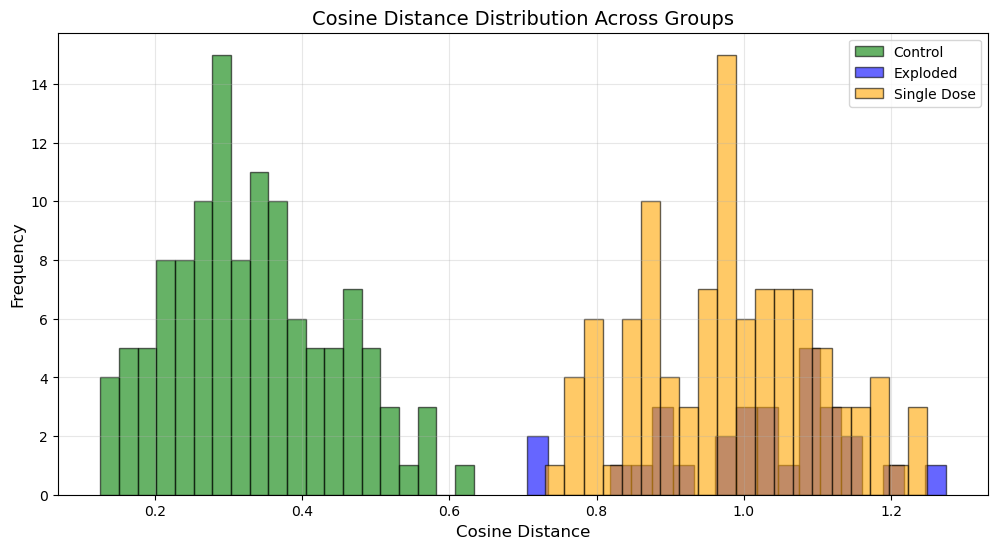

In [3]:
# File paths
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after\cond7.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after\sd.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after\cond7_centroid.npy"

# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    bins=20
)

# Access distances if needed
control_distances = distances["control_cosine_distances"]
exp_distances = distances["exp_cosine_distances"]
sd_distances = distances["sd_cosine_distances"]


C:\Users\k54739\AppData\Local\Temp\ipykernel_10396\3188667897.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

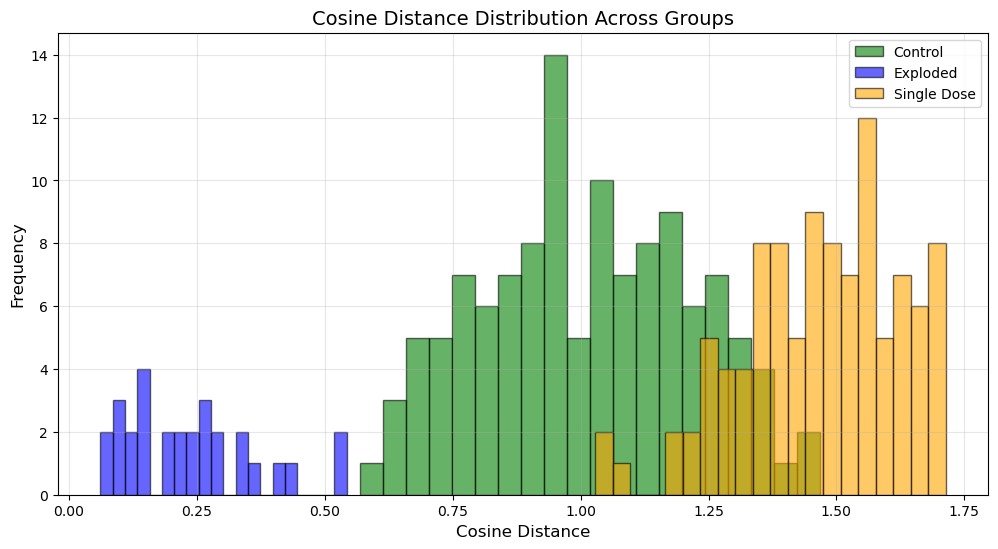

In [4]:
# File paths
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after\cond7.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after\sd.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after\ex_centroid.npy"

# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    bins=20
)

# Access distances if needed
control_distances = distances["control_cosine_distances"]
exp_distances = distances["exp_cosine_distances"]
sd_distances = distances["sd_cosine_distances"]


C:\Users\k54739\AppData\Local\Temp\ipykernel_10396\3188667897.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

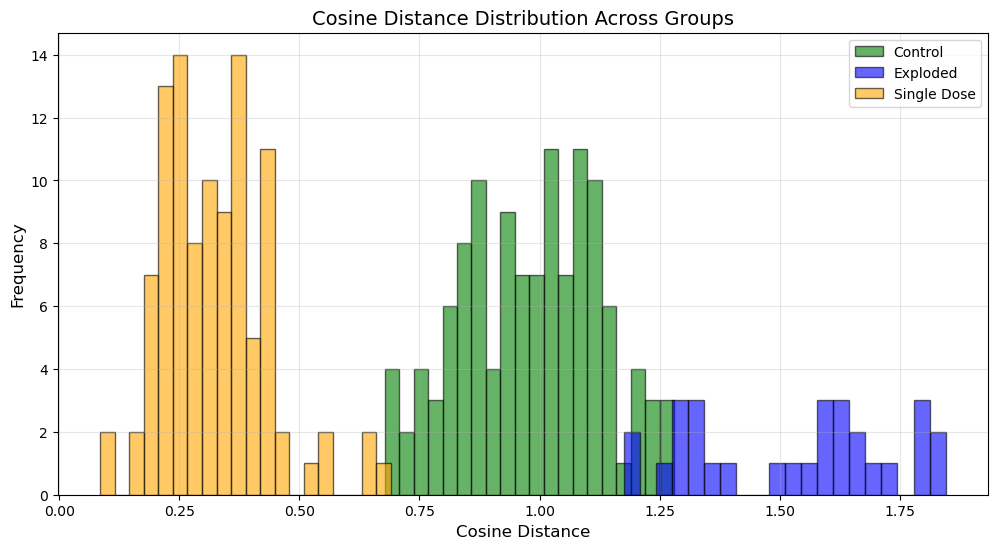

In [5]:
# File paths
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after\cond7.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after\sd.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after\sd_centroid.npy"

# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    bins=20
)

# Access distances if needed
control_distances = distances["control_cosine_distances"]
exp_distances = distances["exp_cosine_distances"]
sd_distances = distances["sd_cosine_distances"]


In [6]:

cond7_centroid = np.load("cond7_centroid.npy")

In [8]:
cosine_centroid = cond7_centroid.reshape(1, -1)

In [9]:
cosine_centroid.shape

(1, 512)

C:\Users\k54739\AppData\Local\Temp\ipykernel_17164\3188667897.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

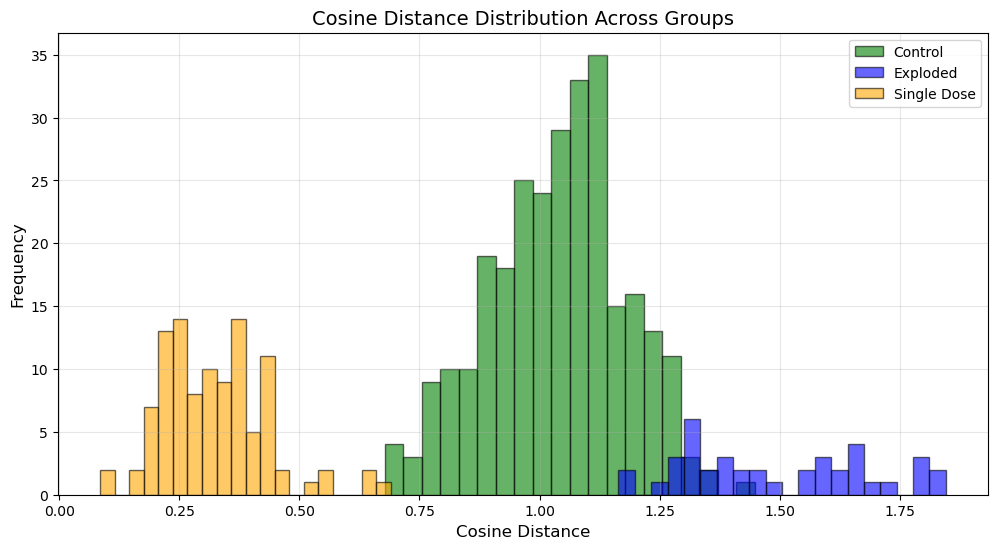

In [6]:
# File paths
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\cond7_curated_280.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd103_centroid.npy"

# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    bins=20
)

# Access distances if needed
control_distances = distances["control_cosine_distances"]
exp_distances = distances["exp_cosine_distances"]
sd_distances = distances["sd_cosine_distances"]


C:\Users\k54739\AppData\Local\Temp\ipykernel_17164\3188667897.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

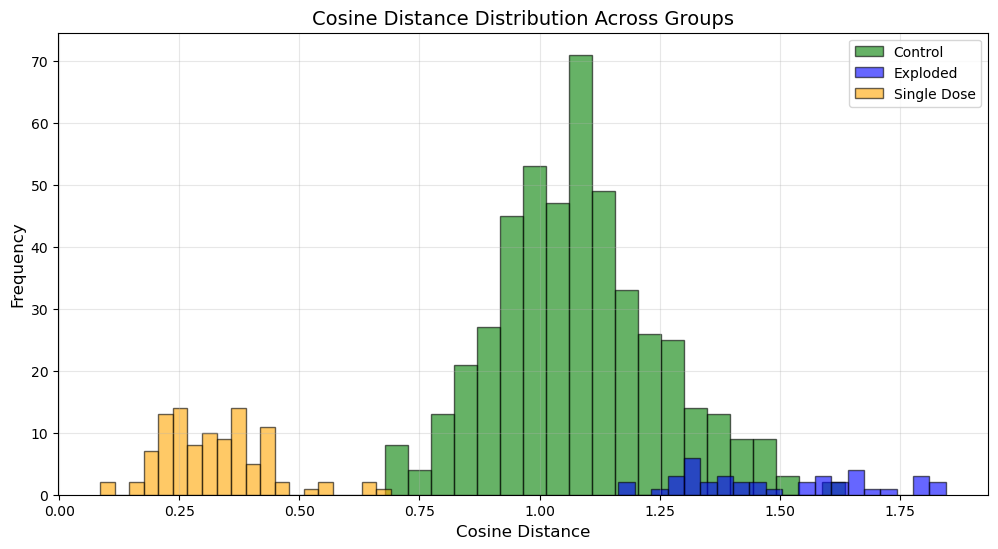

In [32]:
# File paths
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\cond7_all.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd103_centroid.npy"

# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    bins=20
)

# Access distances if needed
control_distances = distances["control_cosine_distances"]
exp_distances = distances["exp_cosine_distances"]
sd_distances = distances["sd_cosine_distances"]


In [13]:
import torch
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def cal_and_plot_cosine_distances(exp_path, control_path, sd_path, centroid_path,ds_closeto_sd_path, bins=20):
    """
    Calculate cosine distances between a centroid and features from multiple groups,
    then plot histograms of these distances.

    Parameters:
        exp_path (str): Path to the exploded features .pt file.
        control_path (str): Path to the control features .pt file.
        sd_path (str): Path to the single-dose features .pt file.
        centroid_path (str): Path to the centroid .pt file.
        bins (int): Number of bins for the histogram.
    """
    # Load data
    exp = torch.load(exp_path)
    control = torch.load(control_path)
    sd = torch.load(sd_path)
    ds_closeto_sd = torch.load(ds_closeto_sd_path)
    cosine_centroid = np.load(centroid_path)

    # Convert tensors to NumPy arrays and normalize
    exp_np_norm = exp.numpy()
    control_np_norm = control.numpy()
    sd_np_norm = sd.numpy()
    ds_closeto_sd_norm = ds_closeto_sd.numpy()

    # Ensure centroid is reshaped correctly
    cosine_centroid = cosine_centroid.reshape(1, -1)  # Shape: [1, 512]

    # Calculate cosine distances
    control_cosine_distances = 1 - cosine_similarity(control_np_norm, cosine_centroid).flatten()
    exp_cosine_distances = 1 - cosine_similarity(exp_np_norm, cosine_centroid).flatten()
    sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()
    ds_closeto_sd_cosine_distances = 1 - cosine_similarity(ds_closeto_sd_norm, cosine_centroid).flatten()

    # Plot histograms
    plt.figure(figsize=(12, 6))
    plt.hist(control_cosine_distances, bins=bins, alpha=0.6, label="Control", color="green", edgecolor="black")
    plt.hist(exp_cosine_distances, bins=bins, alpha=0.6, label="Exploded", color="blue", edgecolor="black")
    plt.hist(sd_cosine_distances, bins=bins, alpha=0.6, label="Single Dose", color="orange", edgecolor="black")
    plt.hist(ds_closeto_sd_cosine_distances, bins=bins, alpha=0.6, label="ds close to sd", color="red", edgecolor="black")

    # Customize plot
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

    # Return calculated distances for further use
    return {
        "control_cosine_distances": control_cosine_distances,
        "exp_cosine_distances": exp_cosine_distances,
        "sd_cosine_distances": sd_cosine_distances,
        "ds_closeto_sd_cosine_distances": ds_closeto_sd_cosine_distances

    }


C:\Users\k54739\AppData\Local\Temp\ipykernel_17164\1989908402.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

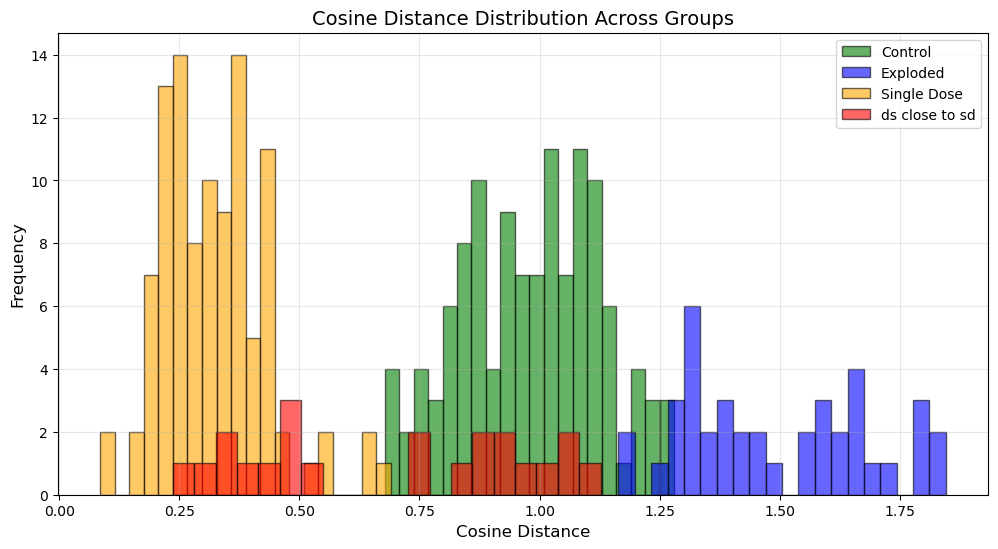

In [17]:
# File paths
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\cond7_120.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd103_centroid.npy"
ds_closeto_sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ds_closeto_sd.pt"


# Call the function
distances = cal_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    ds_closeto_sd_save_path_torch,
    bins=20
)

# Access distances if needed
control_distances = distances["control_cosine_distances"]
exp_distances = distances["exp_cosine_distances"]
sd_distances = distances["sd_cosine_distances"]
ds_closeto_sd_distances = distances["ds_closeto_sd_cosine_distances"]


In [2]:
# File paths
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\cond7_120.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd103_centroid.npy"
ds_closeto_sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ds_closeto_sd.pt"

In [3]:
exp = torch.load(exp_save_path_torch)
control = torch.load(control_save_path_torch)
sd = torch.load(sd_save_path_torch)
DS = torch.load(ds_closeto_sd_save_path_torch)
print(exp.shape)
print(control.shape)
print(sd.shape)
print(DS.shape)

torch.Size([40, 20])
torch.Size([120, 20])
torch.Size([103, 20])
torch.Size([22, 20])


C:\Users\k54739\AppData\Local\Temp\ipykernel_17888\4225645748.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_save_path_torch)
C:\Users\k54739\AppDa

In [18]:
# Pair IDs with their corresponding cosine distances
ds_closeto_sd_ids = np.arange(len(ds_closeto_sd_distances))  # Assuming IDs are indices
ds_closeto_sd_pairs = list(zip(ds_closeto_sd_ids, ds_closeto_sd_distances))

# Sort the pairs by cosine distance (ascending order)
sorted_ds_closeto_sd_pairs = sorted(ds_closeto_sd_pairs, key=lambda x: x[1])

# Print the sorted results
print("ID\tCosine Distance")
for id_, distance in sorted_ds_closeto_sd_pairs:
    print(f"{id_}\t{distance:.4f}")


ID	Cosine Distance
12	0.2367
10	0.3116
2	0.3612
11	0.3653
13	0.3752
15	0.4332
1	0.4643
14	0.4673
3	0.4705
0	0.5239
7	0.7340
9	0.7510
4	0.8191
5	0.8726
6	0.8761
8	0.9086
16	0.9211
20	0.9549
18	1.0316
19	1.0393
17	1.0733
21	1.1271


In [21]:
import pickle

# Load features and paths
with open("dsclosesd.pkl", "rb") as f:
    data = pickle.load(f)

# Separate features and paths
features = [item[0] for item in data]
ds_closeto_sd_paths  = [item[1] for item in data]

# Convert features back to a tensor
ds_closeto_sd = torch.tensor(features)


In [22]:
type(ds_closeto_sd)

torch.Tensor


Sorted ds_closeto_sd distances and paths:
Cosine Distance: 0.2360, Path: C:\Users\k54739\Bibi_new_thesis\thesis\classification\ds_closeto_sd\ds42_g2_B05-T01.tiff
Cosine Distance: 0.3165, Path: C:\Users\k54739\Bibi_new_thesis\thesis\classification\ds_closeto_sd\ds42_g2_B03-T01.tiff
Cosine Distance: 0.3341, Path: C:\Users\k54739\Bibi_new_thesis\thesis\classification\ds_closeto_sd\ds1b_g5_E4.tif
Cosine Distance: 0.3657, Path: C:\Users\k54739\Bibi_new_thesis\thesis\classification\ds_closeto_sd\ds42_g2_B06-T01.tiff
Cosine Distance: 0.3967, Path: C:\Users\k54739\Bibi_new_thesis\thesis\classification\ds_closeto_sd\ds42_g2_B04-T01.tiff
Cosine Distance: 0.4204, Path: C:\Users\k54739\Bibi_new_thesis\thesis\classification\ds_closeto_sd\ds42_g5_E03-T01.tiff
Cosine Distance: 0.4240, Path: C:\Users\k54739\Bibi_new_thesis\thesis\classification\ds_closeto_sd\ds42_g5_E02-T01.tiff
Cosine Distance: 0.4470, Path: C:\Users\k54739\Bibi_new_thesis\thesis\classification\ds_closeto_sd\ds1b_g5_E3.tif
Cosine Di

C:\Users\k54739\AppData\Local\Temp\ipykernel_17164\3295794841.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

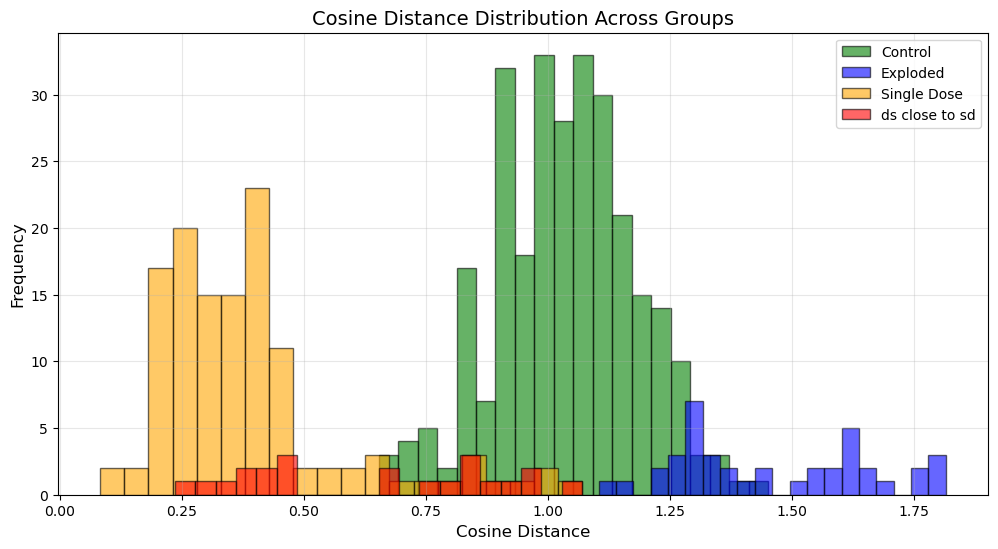

In [42]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pickle

def cal_and_plot(exp_path, control_path, sd_path, centroid_path, ds_closeto_sd_features, ds_closeto_sd_paths, bins=20):
    """
    Calculate cosine distances between a centroid and features from multiple groups,
    then plot histograms of these distances. Also prints ds_closeto_sd features and their corresponding paths in ascending order of cosine distances.

    Parameters:
        exp_path (str): Path to the exploded features .pt file.
        control_path (str): Path to the control features .pt file.
        sd_path (str): Path to the single-dose features .pt file.
        centroid_path (str): Path to the centroid .npy file.
        ds_closeto_sd_features (torch.Tensor): Features for ds_closeto_sd.
        ds_closeto_sd_paths (list): Corresponding paths for ds_closeto_sd features.
        bins (int): Number of bins for the histogram.
    """
    # Load data
    exp = torch.load(exp_path)
    control = torch.load(control_path)
    sd = torch.load(sd_path)
    cosine_centroid = np.load(centroid_path)

    # Convert tensors to NumPy arrays
    exp_np_norm = exp.numpy()
    control_np_norm = control.numpy()
    sd_np_norm = sd.numpy()
    ds_closeto_sd_norm = ds_closeto_sd_features.numpy()

    # Ensure centroid is reshaped correctly
    cosine_centroid = cosine_centroid.reshape(1, -1)  # Shape: [1, 512]

    # Calculate cosine distances
    control_cosine_distances = 1 - cosine_similarity(control_np_norm, cosine_centroid).flatten()
    exp_cosine_distances = 1 - cosine_similarity(exp_np_norm, cosine_centroid).flatten()
    sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()
    ds_closeto_sd_cosine_distances = 1 - cosine_similarity(ds_closeto_sd_norm, cosine_centroid).flatten()

    # Combine distances with paths
    ds_closeto_sd_with_paths = list(zip(ds_closeto_sd_cosine_distances, ds_closeto_sd_paths))
    ds_closeto_sd_with_paths_sorted = sorted(ds_closeto_sd_with_paths, key=lambda x: x[0])  # Sort by cosine distance

    # Print sorted distances and paths
    print("\nSorted ds_closeto_sd distances and paths:")
    for distance, path in ds_closeto_sd_with_paths_sorted:
        print(f"Cosine Distance: {distance:.4f}, Path: {path}")

    # Plot histograms
    plt.figure(figsize=(12, 6))
    plt.hist(control_cosine_distances, bins=bins, alpha=0.6, label="Control", color="green", edgecolor="black")
    plt.hist(exp_cosine_distances, bins=bins, alpha=0.6, label="Exploded", color="blue", edgecolor="black")
    plt.hist(sd_cosine_distances, bins=bins, alpha=0.6, label="Single Dose", color="orange", edgecolor="black")
    plt.hist(ds_closeto_sd_cosine_distances, bins=bins, alpha=0.6, label="ds close to sd", color="red", edgecolor="black")

    # Customize plot
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

    # Return calculated distances for further use
    return {
        "control_cosine_distances": control_cosine_distances,
        "exp_cosine_distances": exp_cosine_distances,
        "sd_cosine_distances": sd_cosine_distances,
        "ds_closeto_sd_cosine_distances": ds_closeto_sd_cosine_distances,
    }

# File paths
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\cond7_curated_280.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd_dsclose.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd125_centroid.npy"

# Load features and paths
with open("dsclosesd.pkl", "rb") as f:
    data = pickle.load(f)

# Separate features and paths
features = [item[0] for item in data]
ds_closeto_sd_paths = [item[1] for item in data]

# Convert features back to a tensor
ds_closeto_sd_features = torch.tensor(features)

# Call the function
distances = cal_and_plot(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    ds_closeto_sd_features,
    ds_closeto_sd_paths,
    bins=20
)


C:\Users\k54739\AppData\Local\Temp\ipykernel_17164\3504937528.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

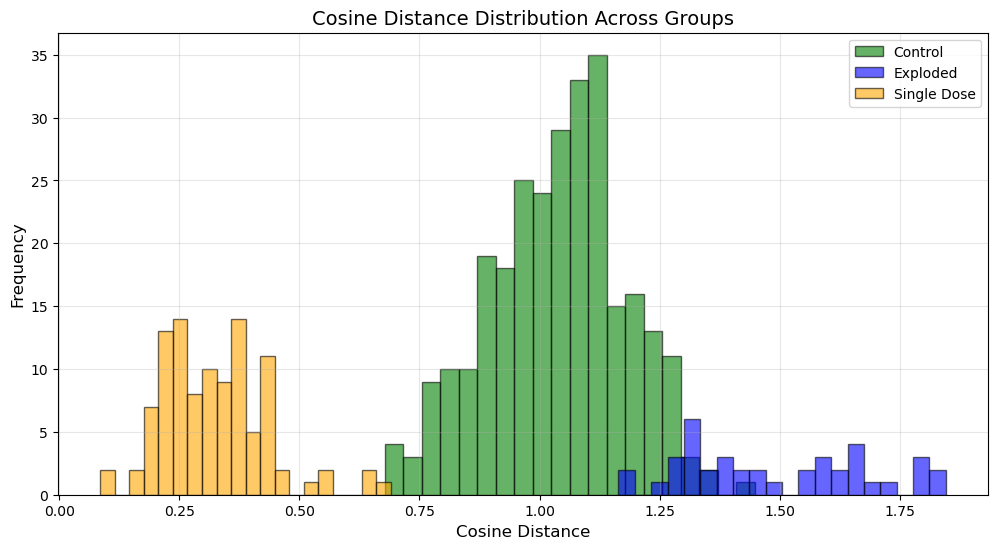


Metrics:
Group-Wise Ranking Accuracy: 0.9739


In [45]:
import torch
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def calculate_and_plot_cosine_distances(exp_path, control_path, sd_path, centroid_path, bins=20):
    """
    Calculate cosine distances between a centroid and features from multiple groups,
    plot histograms of these distances, and compute Group-Wise Ranking Accuracy metric.

    Parameters:
        exp_path (str): Path to the exploded features .pt file.
        control_path (str): Path to the control features .pt file.
        sd_path (str): Path to the single-dose features .pt file.
        centroid_path (str): Path to the centroid .pt file.
        bins (int): Number of bins for the histogram.

    Returns:
        dict: Contains cosine distances and calculated metrics.
    """
    # Load data
    exp = torch.load(exp_path)
    control = torch.load(control_path)
    sd = torch.load(sd_path)
    cosine_centroid = np.load(centroid_path)

    # Convert tensors to NumPy arrays and normalize
    exp_np_norm = normalize(exp.numpy(), axis=1)
    control_np_norm = normalize(control.numpy(), axis=1)
    sd_np_norm = normalize(sd.numpy(), axis=1)

    # Ensure centroid is reshaped correctly
    cosine_centroid = cosine_centroid.reshape(1, -1)  # Shape: [1, 512]

    # Calculate cosine distances
    control_cosine_distances = 1 - cosine_similarity(control_np_norm, cosine_centroid).flatten()
    exp_cosine_distances = 1 - cosine_similarity(exp_np_norm, cosine_centroid).flatten()
    sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()

    # Plot histograms
    plt.figure(figsize=(12, 6))
    plt.hist(control_cosine_distances, bins=bins, alpha=0.6, label="Control", color="green", edgecolor="black")
    plt.hist(exp_cosine_distances, bins=bins, alpha=0.6, label="Exploded", color="blue", edgecolor="black")
    plt.hist(sd_cosine_distances, bins=bins, alpha=0.6, label="Single Dose", color="orange", edgecolor="black")

    # Customize plot
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

    # Compute Group-Wise Ranking Accuracy
    group_wise_accuracy = compute_group_wise_ranking_accuracy(control_cosine_distances, exp_cosine_distances, sd_cosine_distances)

    # Print metrics
    print("\nMetrics:")
    print(f"Group-Wise Ranking Accuracy: {group_wise_accuracy:.4f}")

    # Return calculated distances and metrics for further use
    return {
        "control_cosine_distances": control_cosine_distances,
        "exp_cosine_distances": exp_cosine_distances,
        "sd_cosine_distances": sd_cosine_distances,
        "group_wise_accuracy": group_wise_accuracy
    }

def compute_group_wise_ranking_accuracy(control, exp, sd):
    """
    Compute the Group-Wise Ranking Accuracy metric.

    Parameters:
        control (np.ndarray): Cosine distances for the control group.
        exp (np.ndarray): Cosine distances for the exploded group.
        sd (np.ndarray): Cosine distances for the single-dose group.

    Returns:
        float: Group-wise ranking accuracy.
    """
    # Combine all distances with their respective group labels
    all_distances = np.concatenate([control, exp, sd])
    all_labels = np.concatenate([np.zeros_like(control), np.ones_like(exp), np.full_like(sd, 2)])

    # Sort all distances along with their labels
    sorted_indices = np.argsort(all_distances)
    sorted_labels = all_labels[sorted_indices]

    # Check if group order is preserved
    correct_transitions = 0
    total_transitions = 0
    for i in range(1, len(sorted_labels)):
        if sorted_labels[i - 1] <= sorted_labels[i]:
            correct_transitions += 1
        total_transitions += 1

    accuracy = correct_transitions / total_transitions if total_transitions > 0 else 0
    return accuracy

# File paths
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\cond7_curated_280.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd103_centroid.npy"

# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    bins=20
)

# Access metrics if needed
group_wise_accuracy = distances["group_wise_accuracy"]


Mean Cosine Distance Scores:
Control Group: 1.0370
Exploded Group: 1.4934
Single Dose Group: 0.3241


C:\Users\k54739\AppData\Local\Temp\ipykernel_17164\3749410762.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

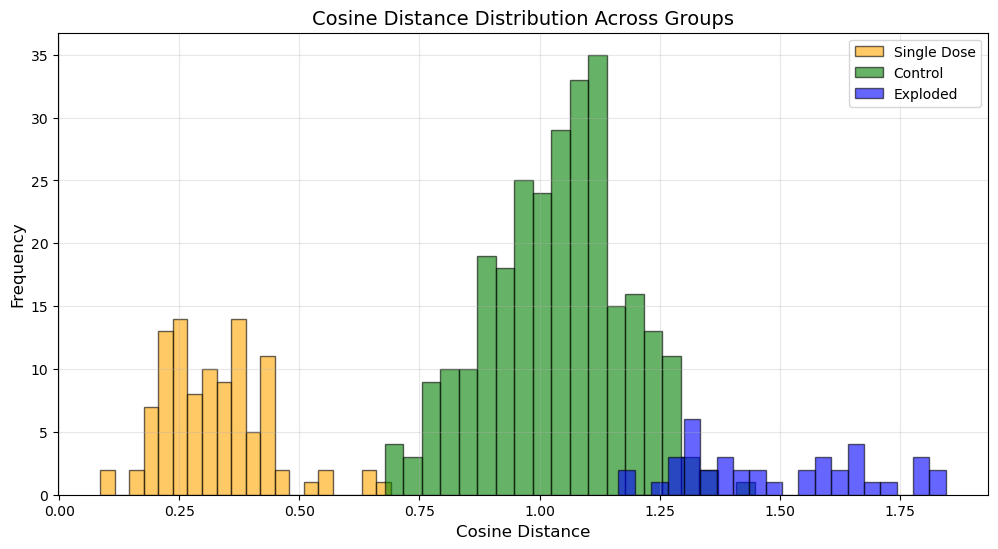


Metrics:
Group-Wise Ranking Accuracy: 0.9763

Dynamic Group Order: ['Single Dose', 'Control', 'Exploded']


In [46]:
import torch
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def calculate_and_plot_cosine_distances(exp_path, control_path, sd_path, centroid_path, bins=20):
    """
    Calculate cosine distances between a centroid and features from multiple groups,
    plot histograms of these distances, and compute Group-Wise Ranking Accuracy metric.

    Parameters:
        exp_path (str): Path to the exploded features .pt file.
        control_path (str): Path to the control features .pt file.
        sd_path (str): Path to the single-dose features .pt file.
        centroid_path (str): Path to the centroid .pt file.
        bins (int): Number of bins for the histogram.

    Returns:
        dict: Contains cosine distances and calculated metrics.
    """
    # Load data
    exp = torch.load(exp_path)
    control = torch.load(control_path)
    sd = torch.load(sd_path)
    cosine_centroid = np.load(centroid_path)

    # Convert tensors to NumPy arrays and normalize
    exp_np_norm = normalize(exp.numpy(), axis=1)
    control_np_norm = normalize(control.numpy(), axis=1)
    sd_np_norm = normalize(sd.numpy(), axis=1)

    # Ensure centroid is reshaped correctly
    cosine_centroid = cosine_centroid.reshape(1, -1)  # Shape: [1, 512]

    # Calculate cosine distances
    control_cosine_distances = 1 - cosine_similarity(control_np_norm, cosine_centroid).flatten()
    exp_cosine_distances = 1 - cosine_similarity(exp_np_norm, cosine_centroid).flatten()
    sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()

    # Calculate mean distances for each group
    mean_control = np.mean(control_cosine_distances)
    mean_exp = np.mean(exp_cosine_distances)
    mean_sd = np.mean(sd_cosine_distances)

    # Print mean scores
    print("Mean Cosine Distance Scores:")
    print(f"Control Group: {mean_control:.4f}")
    print(f"Exploded Group: {mean_exp:.4f}")
    print(f"Single Dose Group: {mean_sd:.4f}")

    # Sort groups dynamically based on mean distances
    group_order = sorted(
        [(mean_control, control_cosine_distances, "Control", "green"),
         (mean_exp, exp_cosine_distances, "Exploded", "blue"),
         (mean_sd, sd_cosine_distances, "Single Dose", "orange")],
        key=lambda x: x[0]  # Sort by mean distance
    )

    # Plot histograms dynamically in sorted order
    plt.figure(figsize=(12, 6))
    for _, distances, label, color in group_order:
        plt.hist(distances, bins=bins, alpha=0.6, label=label, color=color, edgecolor="black")

    # Customize plot
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

    # Compute Group-Wise Ranking Accuracy dynamically
    all_distances, all_labels = [], []
    for i, (_, distances, label, _) in enumerate(group_order):
        all_distances.append(distances)
        all_labels.append(np.full_like(distances, i))  # Assign dynamic labels based on sorted order

    all_distances = np.concatenate(all_distances)
    all_labels = np.concatenate(all_labels)
    
    group_wise_accuracy = compute_group_wise_ranking_accuracy(all_distances, all_labels)

    # Print metrics
    print("\nMetrics:")
    print(f"Group-Wise Ranking Accuracy: {group_wise_accuracy:.4f}")

    # Return calculated distances and metrics for further use
    return {
        "control_cosine_distances": control_cosine_distances,
        "exp_cosine_distances": exp_cosine_distances,
        "sd_cosine_distances": sd_cosine_distances,
        "group_wise_accuracy": group_wise_accuracy,
        "mean_scores": {
            "Control": mean_control,
            "Exploded": mean_exp,
            "Single Dose": mean_sd
        },
        "group_order": [group[2] for group in group_order]  # Return the sorted group labels
    }

def compute_group_wise_ranking_accuracy(all_distances, all_labels):
    """
    Compute the Group-Wise Ranking Accuracy metric.

    Parameters:
        all_distances (np.ndarray): Combined cosine distances from all groups.
        all_labels (np.ndarray): Corresponding group labels for the distances.

    Returns:
        float: Group-wise ranking accuracy.
    """
    # Sort all distances along with their labels
    sorted_indices = np.argsort(all_distances)
    sorted_labels = all_labels[sorted_indices]

    # Check if group order is preserved
    correct_transitions = 0
    total_transitions = 0
    for i in range(1, len(sorted_labels)):
        if sorted_labels[i - 1] <= sorted_labels[i]:
            correct_transitions += 1
        total_transitions += 1

    accuracy = correct_transitions / total_transitions if total_transitions > 0 else 0
    return accuracy

# File paths
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\cond7_curated_280.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd103_centroid.npy"

# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    bins=20
)

# Access metrics if needed
group_wise_accuracy = distances["group_wise_accuracy"]
group_order = distances["group_order"]
print("\nDynamic Group Order:", group_order)


Mean Cosine Distance Scores:
Control Group: 1.0370
Exploded Group: 1.4934
Single Dose Group: 0.3241


C:\Users\k54739\AppData\Local\Temp\ipykernel_17164\393345704.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\Te

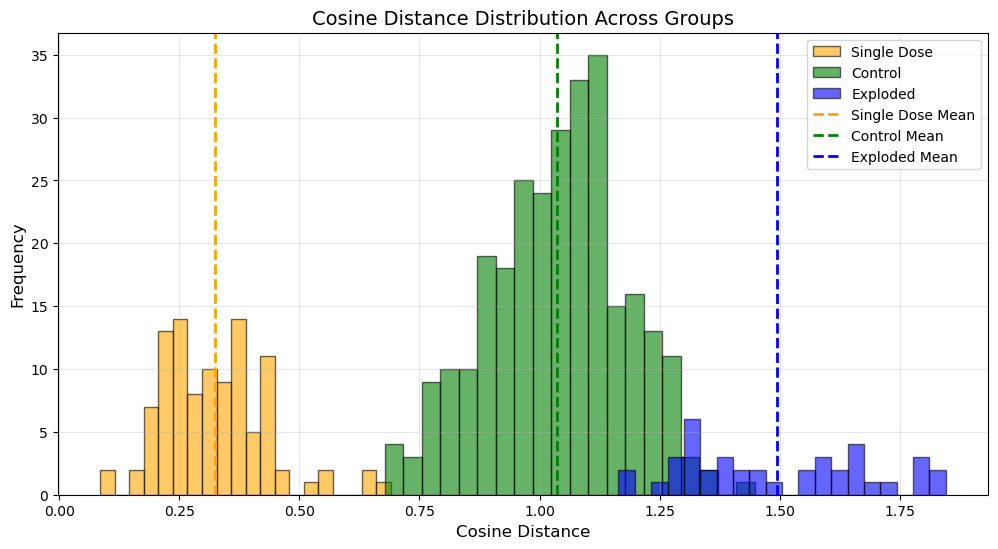


Metrics:
Group-Wise Ranking Accuracy: 0.9763

Dynamic Group Order and Mean Cosine Distances:


KeyError: 'mean_single_dose'

In [49]:
import torch
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def calculate_and_plot_cosine_distances(exp_path, control_path, sd_path, centroid_path, bins=20):
    """
    Calculate cosine distances between a centroid and features from multiple groups,
    plot histograms of these distances, and compute Group-Wise Ranking Accuracy metric.

    Parameters:
        exp_path (str): Path to the exploded features .pt file.
        control_path (str): Path to the control features .pt file.
        sd_path (str): Path to the single-dose features .pt file.
        centroid_path (str): Path to the centroid .pt file.
        bins (int): Number of bins for the histogram.

    Returns:
        dict: Contains cosine distances and calculated metrics.
    """
    # Load data
    exp = torch.load(exp_path)
    control = torch.load(control_path)
    sd = torch.load(sd_path)
    cosine_centroid = np.load(centroid_path)

    # Convert tensors to NumPy arrays and normalize
    exp_np_norm = normalize(exp.numpy(), axis=1)
    control_np_norm = normalize(control.numpy(), axis=1)
    sd_np_norm = normalize(sd.numpy(), axis=1)

    # Ensure centroid is reshaped correctly
    cosine_centroid = cosine_centroid.reshape(1, -1)  # Shape: [1, 512]

    # Calculate cosine distances
    control_cosine_distances = 1 - cosine_similarity(control_np_norm, cosine_centroid).flatten()
    exp_cosine_distances = 1 - cosine_similarity(exp_np_norm, cosine_centroid).flatten()
    sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()

    # Calculate mean distances for each group
    mean_control = np.mean(control_cosine_distances)
    mean_exp = np.mean(exp_cosine_distances)
    mean_sd = np.mean(sd_cosine_distances)

    # Print mean scores
    print("Mean Cosine Distance Scores:")
    print(f"Control Group: {mean_control:.4f}")
    print(f"Exploded Group: {mean_exp:.4f}")
    print(f"Single Dose Group: {mean_sd:.4f}")

    # Sort groups dynamically based on mean distances
    group_order = sorted(
        [(mean_control, control_cosine_distances, "Control", "green"),
         (mean_exp, exp_cosine_distances, "Exploded", "blue"),
         (mean_sd, sd_cosine_distances, "Single Dose", "orange")],
        key=lambda x: x[0]  # Sort by mean distance
    )

    # Plot histograms dynamically in sorted order
    plt.figure(figsize=(12, 6))
    for _, distances, label, color in group_order:
        plt.hist(distances, bins=bins, alpha=0.6, label=label, color=color, edgecolor="black")

    # Add vertical lines for mean distances
    # Add vertical lines for mean distances
    for _, _, label, color in group_order:
        if label == "Control":
            mean_distance = mean_control
        elif label == "Exploded":
            mean_distance = mean_exp
        elif label == "Single Dose":
            mean_distance = mean_sd
        else:
            continue  # In case of any other labels

        # Add the vertical line for mean distance
        plt.axvline(mean_distance, color=color, linestyle="dashed", linewidth=2, label=f"{label} Mean")

    # Customize plot
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

    # Compute Group-Wise Ranking Accuracy dynamically
    all_distances, all_labels = [], []
    for i, (_, distances, label, _) in enumerate(group_order):
        all_distances.append(distances)
        all_labels.append(np.full_like(distances, i))  # Assign dynamic labels based on sorted order

    all_distances = np.concatenate(all_distances)
    all_labels = np.concatenate(all_labels)
    
    group_wise_accuracy = compute_group_wise_ranking_accuracy(all_distances, all_labels)

    # Print metrics
    print("\nMetrics:")
    print(f"Group-Wise Ranking Accuracy: {group_wise_accuracy:.4f}")
    print("\nDynamic Group Order and Mean Cosine Distances:")
    for _, _, label, _ in group_order:
        mean_distance = locals()[f"mean_{label.lower().replace(' ', '_')}"]
        print(f"{label} Group Mean Cosine Distance: {mean_distance:.4f}")

    # Return calculated distances and metrics for further use
    return {
        "control_cosine_distances": control_cosine_distances,
        "exp_cosine_distances": exp_cosine_distances,
        "sd_cosine_distances": sd_cosine_distances,
        "group_wise_accuracy": group_wise_accuracy,
        "mean_scores": {
            "Control": mean_control,
            "Exploded": mean_exp,
            "Single Dose": mean_sd
        },
        "group_order": [group[2] for group in group_order]  # Return the sorted group labels
    }

def compute_group_wise_ranking_accuracy(all_distances, all_labels):
    """
    Compute the Group-Wise Ranking Accuracy metric.

    Parameters:
        all_distances (np.ndarray): Combined cosine distances from all groups.
        all_labels (np.ndarray): Corresponding group labels for the distances.

    Returns:
        float: Group-wise ranking accuracy.
    """
    # Sort all distances along with their labels
    sorted_indices = np.argsort(all_distances)
    sorted_labels = all_labels[sorted_indices]

    # Check if group order is preserved
    correct_transitions = 0
    total_transitions = 0
    for i in range(1, len(sorted_labels)):
        if sorted_labels[i - 1] <= sorted_labels[i]:
            correct_transitions += 1
        total_transitions += 1

    accuracy = correct_transitions / total_transitions if total_transitions > 0 else 0
    return accuracy

# File paths
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\cond7_curated_280.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd103_centroid.npy"

# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    bins=20
)

# Access metrics if needed
group_wise_accuracy = distances["group_wise_accuracy"]
group_order = distances["group_order"]
print("\nDynamic Group Order:", group_order)


Mean Cosine Distance Scores:
Control Group: 1.0370
Exploded Group: 1.4934
Single Dose Group: 0.3241

Dynamic Group Order and Mean Cosine Distances:
Single Dose Group Mean Cosine Distance: 0.3241
Control Group Mean Cosine Distance: 1.0370
Exploded Group Mean Cosine Distance: 1.4934


C:\Users\k54739\AppData\Local\Temp\ipykernel_17164\1468762094.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

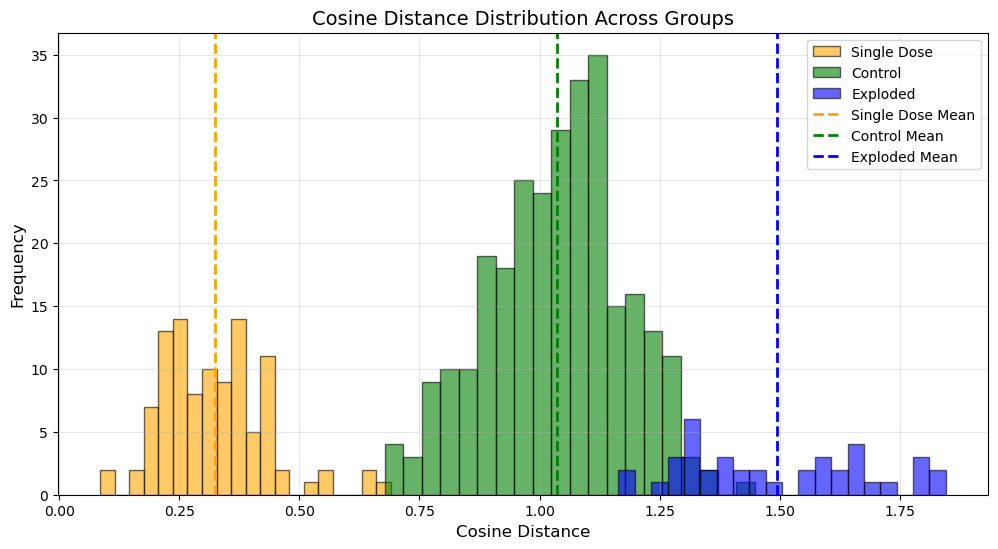


Metrics:
Group-Wise Ranking Accuracy: 0.9763

Dynamic Group Order: ['Single Dose', 'Control', 'Exploded']


Mean Cosine Distance Scores:
Control Group: 1.0370
Exploded Group: 1.4934
Single Dose Group: 0.3241

Dynamic Group Order and Mean Cosine Distances:
Single Dose Group Mean Cosine Distance: 0.3241
Control Group Mean Cosine Distance: 1.0370
Exploded Group Mean Cosine Distance: 1.4934


C:\Users\k54739\AppData\Local\Temp\ipykernel_17164\1468762094.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

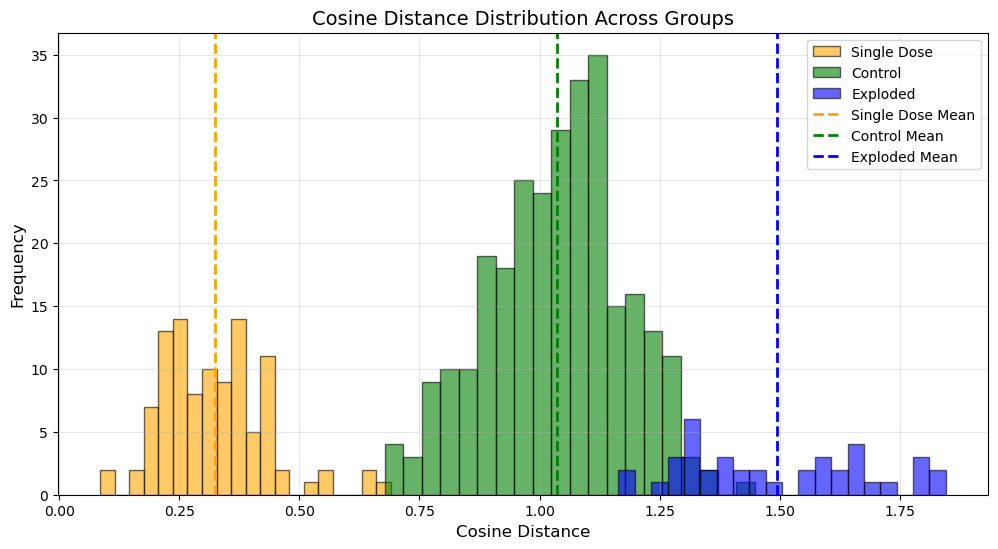


Metrics:
Group-Wise Ranking Accuracy: 0.9763

Dynamic Group Order: ['Single Dose', 'Control', 'Exploded']


In [51]:
import torch
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def calculate_and_plot_cosine_distances(exp_path, control_path, sd_path, centroid_path, bins=20):
    """
    Calculate cosine distances between a centroid and features from multiple groups,
    plot histograms of these distances, and compute Group-Wise Ranking Accuracy metric.

    Parameters:
        exp_path (str): Path to the exploded features .pt file.
        control_path (str): Path to the control features .pt file.
        sd_path (str): Path to the single-dose features .pt file.
        centroid_path (str): Path to the centroid .pt file.
        bins (int): Number of bins for the histogram.

    Returns:
        dict: Contains cosine distances and calculated metrics.
    """
    # Load data
    exp = torch.load(exp_path)
    control = torch.load(control_path)
    sd = torch.load(sd_path)
    cosine_centroid = np.load(centroid_path)

    # Convert tensors to NumPy arrays and normalize
    exp_np_norm = normalize(exp.numpy(), axis=1)
    control_np_norm = normalize(control.numpy(), axis=1)
    sd_np_norm = normalize(sd.numpy(), axis=1)

    # Ensure centroid is reshaped correctly
    cosine_centroid = cosine_centroid.reshape(1, -1)  # Shape: [1, 512]

    # Calculate cosine distances
    control_cosine_distances = 1 - cosine_similarity(control_np_norm, cosine_centroid).flatten()
    exp_cosine_distances = 1 - cosine_similarity(exp_np_norm, cosine_centroid).flatten()
    sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()

    # Calculate mean distances for each group
    mean_control = np.mean(control_cosine_distances)
    mean_exp = np.mean(exp_cosine_distances)
    mean_sd = np.mean(sd_cosine_distances)

    # Print mean scores
    print("Mean Cosine Distance Scores:")
    print(f"Control Group: {mean_control:.4f}")
    print(f"Exploded Group: {mean_exp:.4f}")
    print(f"Single Dose Group: {mean_sd:.4f}")

    # Sort groups dynamically based on mean distances
    group_order = sorted(
        [(mean_control, control_cosine_distances, "Control", "green"),
         (mean_exp, exp_cosine_distances, "Exploded", "blue"),
         (mean_sd, sd_cosine_distances, "Single Dose", "orange")],
        key=lambda x: x[0]  # Sort by mean distance
    )

    # Map labels to the corresponding mean distance
    mean_map = {
        "Control": mean_control,
        "Exploded": mean_exp,
        "Single Dose": mean_sd
    }

    # Print the group order along with the corresponding mean distances
    print("\nDynamic Group Order and Mean Cosine Distances:")
    for _, _, label, _ in group_order:
        mean_distance = mean_map.get(label, None)
        if mean_distance is not None:
            print(f"{label} Group Mean Cosine Distance: {mean_distance:.4f}")
        else:
            print(f"Mean distance not found for {label}")

    # Plot histograms dynamically in sorted order
    plt.figure(figsize=(12, 6))
    for _, distances, label, color in group_order:
        plt.hist(distances, bins=bins, alpha=0.6, label=label, color=color, edgecolor="black")

    # Add vertical lines for mean distances
    for _, _, label, color in group_order:
        mean_distance = mean_map.get(label, None)
        if mean_distance is not None:
            plt.axvline(mean_distance, color=color, linestyle="dashed", linewidth=2, label=f"{label} Mean")

    # Customize plot
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

    # Compute Group-Wise Ranking Accuracy dynamically
    all_distances, all_labels = [], []
    for i, (_, distances, label, _) in enumerate(group_order):
        all_distances.append(distances)
        all_labels.append(np.full_like(distances, i))  # Assign dynamic labels based on sorted order

    all_distances = np.concatenate(all_distances)
    all_labels = np.concatenate(all_labels)
    
    group_wise_accuracy = compute_group_wise_ranking_accuracy(all_distances, all_labels)

    # Print metrics
    print("\nMetrics:")
    print(f"Group-Wise Ranking Accuracy: {group_wise_accuracy:.4f}")

    # Return calculated distances and metrics for further use
    return {
        "control_cosine_distances": control_cosine_distances,
        "exp_cosine_distances": exp_cosine_distances,
        "sd_cosine_distances": sd_cosine_distances,
        "group_wise_accuracy": group_wise_accuracy,
        "mean_scores": {
            "Control": mean_control,
            "Exploded": mean_exp,
            "Single Dose": mean_sd
        },
        "group_order": [group[2] for group in group_order]  # Return the sorted group labels
    }

def compute_group_wise_ranking_accuracy(all_distances, all_labels):
    """
    Compute the Group-Wise Ranking Accuracy metric.

    Parameters:
        all_distances (np.ndarray): Combined cosine distances from all groups.
        all_labels (np.ndarray): Corresponding group labels for the distances.

    Returns:
        float: Group-wise ranking accuracy.
    """
    # Sort all distances along with their labels
    sorted_indices = np.argsort(all_distances)
    sorted_labels = all_labels[sorted_indices]

    # Check if group order is preserved
    correct_transitions = 0
    total_transitions = 0
    for i in range(1, len(sorted_labels)):
        if sorted_labels[i - 1] <= sorted_labels[i]:
            correct_transitions += 1
        total_transitions += 1

    accuracy = correct_transitions / total_transitions if total_transitions > 0 else 0
    return accuracy

# File paths
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\cond7_curated_280.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd103_centroid.npy"

# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    bins=20
)

# Access metrics if needed
group_wise_accuracy = distances["group_wise_accuracy"]
group_order = distances["group_order"]
print("\nDynamic Group Order:", group_order)


Mean Cosine Distance Scores:
Control Group: 0.5541
Exploded Group: 1.0614
Single Dose Group: 1.0561

Dynamic Group Order and Mean Cosine Distances:
Control Group Mean Cosine Distance: 0.5541
Single Dose Group Mean Cosine Distance: 1.0561
Exploded Group Mean Cosine Distance: 1.0614


C:\Users\k54739\AppData\Local\Temp\ipykernel_17164\1468762094.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

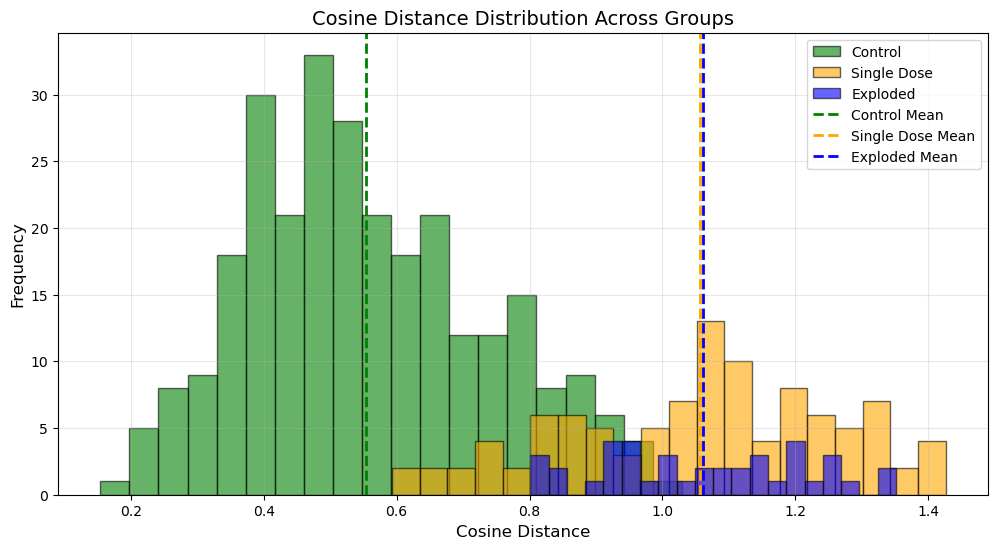


Metrics:
Group-Wise Ranking Accuracy: 0.8697


In [52]:
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\cond7_curated_280.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\curated_control_280_centroid.npy"
# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    bins=20
)

# Access metrics if needed
group_wise_accuracy = distances["group_wise_accuracy"]

Mean Cosine Distance Scores:
Control Group: 1.0378
Exploded Group: 0.2759
Single Dose Group: 1.4606

Dynamic Group Order and Mean Cosine Distances:
Exploded Group Mean Cosine Distance: 0.2759
Control Group Mean Cosine Distance: 1.0378
Single Dose Group Mean Cosine Distance: 1.4606


C:\Users\k54739\AppData\Local\Temp\ipykernel_17164\1468762094.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

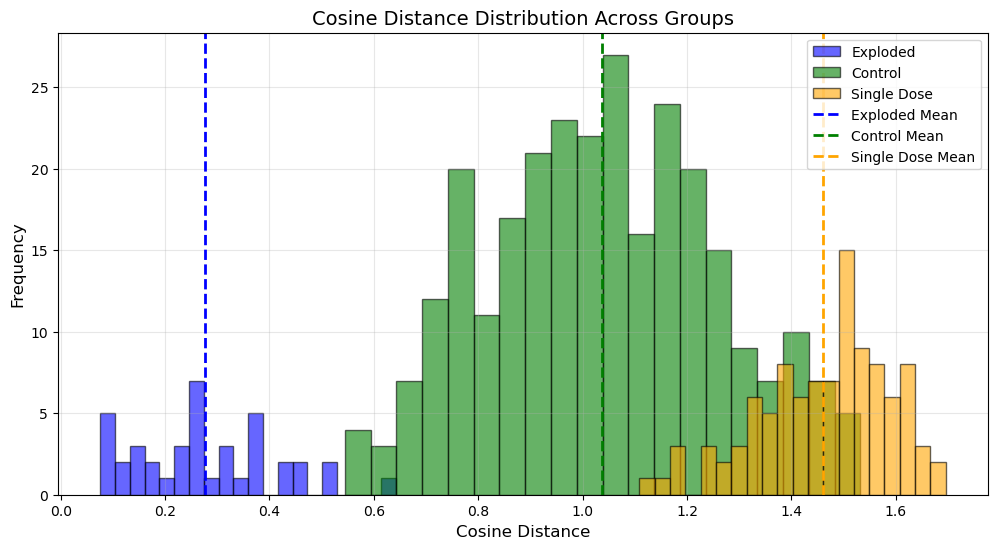


Metrics:
Group-Wise Ranking Accuracy: 0.9218


In [53]:
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\cond7_curated_280.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex40_centroid.npy"
# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    bins=20
)

# Access metrics if needed
group_wise_accuracy = distances["group_wise_accuracy"]